In [32]:
from matplotlib import pyplot as plt
import csv
import numpy as np
import os
import PIL # for reading tif images
import h5py
import datetime as dt
import time

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"
ms = 1e-3
us = 1e-6
kHz = 1e3
kB = 1.38e-23
mRb = 1.443160817941e-25

def eval_str_from_h5(h5_str):
    """a stupid way to evaluate python evaluable strings I saved as ARTIQ datasets"""
    return eval(str(np.array(h5_str))[2:-1])

def get_files_by_criteria(date_filters,name_filters,condition,start_dir=results,include_path=True,print_filenames=False):
    file_list = []
    for root, dirs, files in os.walk(start_dir,topdown=False):
        for name in files:
            if True in set([x in root for x in date_filters]):
                if True in set([x in name for x in name_filters]):
                    filename = os.path.join(root, name)
                    try:
                        h5py.File(filename)
                        if condition(filename):
                            if not include_path:
                                filename = name
                                if print_filenames:
                                    print(filename)
                            file_list.append(filename)
                    except OSError:
                        print(f"skipping {filename}, which is corrupt")
    return file_list

## predicted trap frequencies

In [10]:
w0 = 0.7e-6
lmbda = 8.52e-7
zR = np.pi*w0**2/lmbda
Tfort = 2.5e-3
U0 = kB*Tfort
fr = (2/w0)*np.sqrt(U0/mRb)/(2*np.pi)
fz = (1/zR)*np.sqrt(2*U0/mRb)/(2*np.pi)
print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")

radial freq. 222.33317516218673 kHz
axial freq. 60.908927788837765 kHz


In [11]:
w0 = 0.7e-6
lmbda = 8.52e-7
zR = np.pi*w0**2/lmbda
Tfort = 1e-3
U0 = kB*Tfort
fr = (2/w0)*np.sqrt(U0/mRb)/(2*np.pi)
fz = (1/zR)*np.sqrt(2*U0/mRb)/(2*np.pi)
print("radial freq.", fr*1e-3, "kHz")
print("axial freq.", fz*1e-3, "kHz")

radial freq. 140.61584658593725 kHz
axial freq. 38.522188330290135 kHz


## January 2024

### 2023.01.20

#### concatenate results from a batch of scans

In [51]:
fnames = get_files_by_criteria(date_filters=["2024-01-19","2024-01-20"], # only find files from these date directories
                               name_filters=["SingleAtomTrapFrequencyScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")

found 32 files


In [52]:
fnames[0][len(results):len(results)+23]

'2024-01-19\\10\\000009512'

In [53]:
 f = h5py.File(os.path.join(results, fname))

Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\10\000009512-SingleAtomTrapFrequencyScan.h5 25 != 800
Exception in C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\14\000009559-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\15\000009560-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\15\000009563-SingleAtomTrapFrequencyScan.h5 212 != 1500
Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\18\000009602-SingleAtomTrapFrequencyScan.h5 25 != 100
Experiment aborted: C:\Networking Experiment\artiq codes\artiq-master\results\2024-01-19\18\000009603-SingleAtomTrapFrequencyScan.h5 73 != 100
Experiment aborted: 

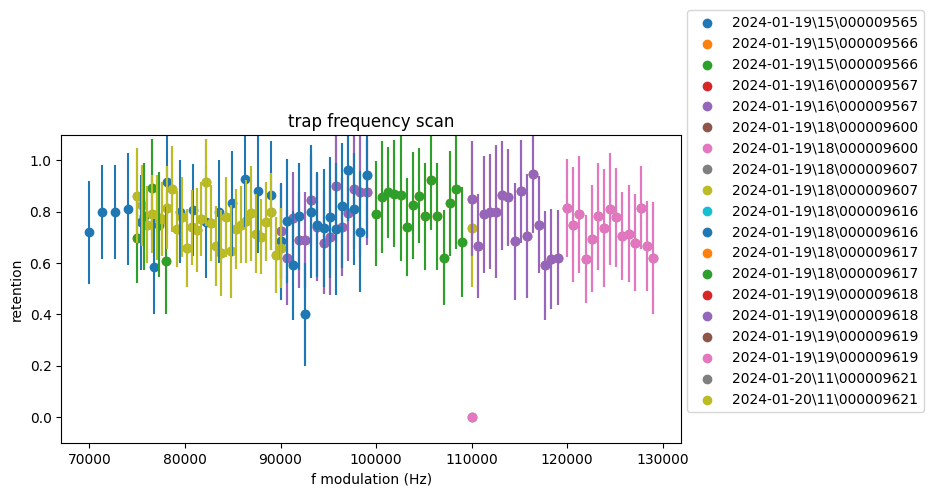

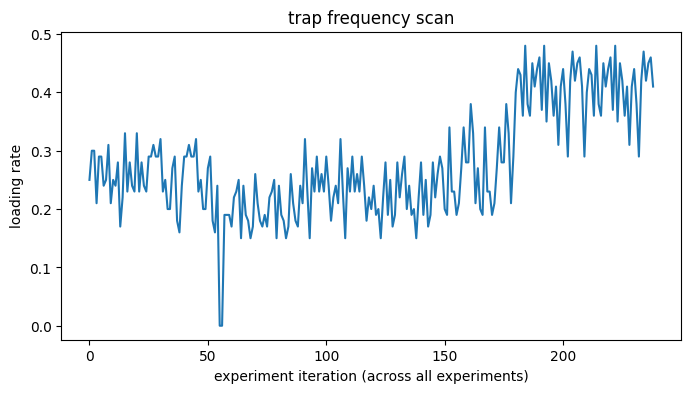

In [54]:
plot_retention = True
cutoff = 270

counts_shot1_list = []
counts_shot2_list = []
loading_rate_list = []
retention_list = []
err_list = []
f_volts_list = []

fig, ax = plt.subplots(figsize=(8,4))

for fname in fnames:
    try:
        f = h5py.File(fname) #os.path.join(results, fname))

        # assume these arguments are the same over the entire batch
        n_measurements = np.uint(f['datasets']['n_measurements'])
        
        FMdev = np.uint(f['datasets']['FM_deviation'])
        f0 = np.uint(f['datasets']['carrier_frequency'])
        f_arr = eval_str_from_h5(f['datasets']['f_modulation_sequence'])
        
        try:
            counts1 = np.array(f['datasets']['photocounts'])[1:]
            counts2 = np.array(f['datasets']['photocounts2'])[1:]

            # if this isn't true, it means there was an error during run(), e.g. the experiment was aborted
            if len(counts1) == len(f_arr)*n_measurements:
                [counts_shot1_list.append(x) for x in counts1]
                [counts_shot2_list.append(x) for x in counts2]
                f_volts = (f_arr - f0)* 5/FMdev
                [f_volts_list.append(f) for f in f_volts]

            
                retention_array = np.zeros(len(f_arr))
                loading_rate_array = np.zeros(len(f_arr))
                
                n_atoms_loaded_array = np.zeros(len(f_arr))
                
                measurements = n_measurements
                
                for i,t in enumerate(f_arr):
                    shot1 = counts1[i*measurements:(i+1)*measurements]
                    shot2 = counts2[i*measurements:(i+1)*measurements]
                    
                    atoms_loaded = [x > cutoff for x in shot1]
                    n_atoms_loaded = sum(atoms_loaded)
                    atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
                    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
                    retention_array[i] = retention_fraction
                    loading_rate_array[i] = n_atoms_loaded/n_measurements
                    n_atoms_loaded_array[i] = n_atoms_loaded

                [retention_list.append(x) for x in retention_array]
                [loading_rate_list.append(x) for x in loading_rate_array]
                
                err_array = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
                [err_list.append(x) for x in err_array]

                if plot_retention:
                    ax.scatter(f_arr, retention_array, label=fname[len(results):len(results)+23])#,color='r')
                    # t_pts = np.linspace(t_arr[0],t_arr[-1],100)
                    ax.errorbar(f_arr,retention_array, err_array, ls='none')#,color='r')
            else:
                print("Experiment aborted:",fname,len(counts1),"!=",len(f_arr)*n_measurements)
        
        except KeyError as e:
            print("Exception in", fname,",",e)
    
    except OSError:
        print(fname, "is corrupt :/")
   
counts_shot1 = np.array(counts_shot1_list)
counts_shot2 = np.array(counts_shot1_list)
loading_rate = np.array(loading_rate_list)

# f_volts = np.array(f_volts_list)
# f_abs = (f_volts+10)*(2*FMdev/10)+f0

if plot_retention:
    ax.set_title('trap frequency scan')
    ax.set_ylabel("retention")
    ax.set_xlabel("f modulation (Hz)")
    ax.set_ylim((-0.1,1.1))
    ax.legend(loc=(1.01,0.1))
    plt.show()

    fig, ax = plt.subplots(figsize=(8,4))
    
    ax.plot(loading_rate)
    ax.set_title('trap frequency scan')
    ax.set_ylabel("loading rate")
    ax.set_xlabel("experiment iteration (across all experiments)")
    plt.show()

(array([  4.,  11.,  21.,  49., 115., 228., 365., 482., 656., 607., 831.,
        880., 816., 733., 632., 519., 416., 302., 220., 137., 154.,  81.,
         36.,  49.,  53.,  56.,  75.,  92., 115., 112., 170., 179., 204.,
        253., 229., 236., 194., 185., 164., 112., 103.,  65.,  52.,  48.,
         19.,  14.,  11.,   7.,   5.,   5.]),
 array([175. , 179.9, 184.8, 189.7, 194.6, 199.5, 204.4, 209.3, 214.2,
        219.1, 224. , 228.9, 233.8, 238.7, 243.6, 248.5, 253.4, 258.3,
        263.2, 268.1, 273. , 277.9, 282.8, 287.7, 292.6, 297.5, 302.4,
        307.3, 312.2, 317.1, 322. , 326.9, 331.8, 336.7, 341.6, 346.5,
        351.4, 356.3, 361.2, 366.1, 371. , 375.9, 380.8, 385.7, 390.6,
        395.5, 400.4, 405.3, 410.2, 415.1, 420. ]),
 <BarContainer object of 50 artists>)

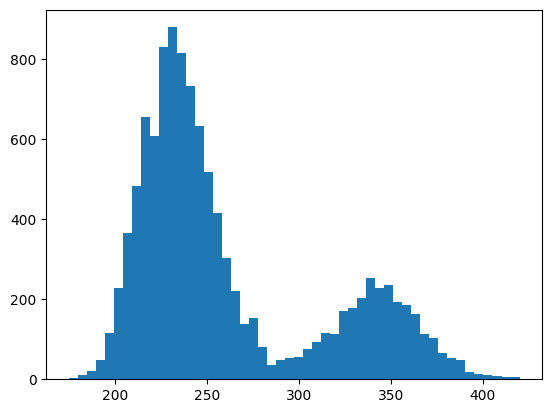

In [50]:
plt.hist(counts_shot1_list,bins=50)

## December 2023

### 2023.12.07

#### concatenate results from a batch of scans

In [ ]:
# i made a mistake when entering the frequency modulation list. 
# i entered absolute frequency steps rather than modulation steps. the first few scans are in the valid
# voltage range but I need to calculate the actual frequencies that the voltages correspond to for these.

# a batch of scans from 70 kHz to ~ 130 kHz with ~700 Hz steps looking for the axial resonance.
# fnames = ["2023-12-06"+x for x in [
#            "\\17\\000008284-SingleAtomTrapFrequencyScan.h5",
#            "\\17\\000008285-SingleAtomTrapFrequencyScan.h5",
#            "\\18\\000008286-SingleAtomTrapFrequencyScan.h5",
#            "\\18\\000008287-SingleAtomTrapFrequencyScan.h5", # everything below this has an invalid voltage for the Rigol.
#            "\\19\\000008288-SingleAtomTrapFrequencyScan.h5",
#            "\\19\\000008289-SingleAtomTrapFrequencyScan.h5",
#            "\\20\\000008290-SingleAtomTrapFrequencyScan.h5",
#            "\\21\\000008291-SingleAtomTrapFrequencyScan.h5"
#            "\\21\\000008292-SingleAtomTrapFrequencyScan.h5", # invalid DAC voltage toward the end
#            "\\22\\000008293-SingleAtomTrapFrequencyScan.h5", # invalid DAC voltage
#           ]]

In [140]:
fnames = ["2023-12-07"+x for x in [
            "\\14\\000008373-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008374-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008375-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008376-SingleAtomTrapFrequencyScan.h5",
            "\\14\\000008377-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008380-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008382-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008383-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008395-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008398-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008402-SingleAtomTrapFrequencyScan.h5",
            "\\15\\000008410-SingleAtomTrapFrequencyScan.h5",
            "\\16\\000008423-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008425-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008426-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008427-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008428-SingleAtomTrapFrequencyScan.h5",
            "\\17\\000008429-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008430-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008431-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008432-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008433-SingleAtomTrapFrequencyScan.h5",
            "\\19\\000008434-SingleAtomTrapFrequencyScan.h5",
            "\\19\\000008435-SingleAtomTrapFrequencyScan.h5"]
]

fnames += ["2023-12-11"+x for x in [
            "\\18\\000008558-SingleAtomTrapFrequencyScan.h5",
            "\\18\\000008559-SingleAtomTrapFrequencyScan.h5",
            "\\18\\000008560-SingleAtomTrapFrequencyScan.h5",
            # "\\18\\000008561-SingleAtomTrapFrequencyScan.h5" # possible resonance. need finer scan
        ]
]

fnames += ["2023-12-12"+x for x in [
            "\\11\\000008567-SingleAtomTrapFrequencyScan.h5"]
]

Exception in 2023-12-07\14\000008375-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Experiment aborted: 2023-12-07\14\000008377-SingleAtomTrapFrequencyScan.h5 159 != 840
Experiment aborted: 2023-12-07\15\000008380-SingleAtomTrapFrequencyScan.h5 13 != 840
Exception in 2023-12-07\15\000008382-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in 2023-12-07\15\000008383-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in 2023-12-07\15\000008395-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Exception in 2023-12-07\15\000008398-SingleAtomTrapFrequencyScan.h5 , "Unable to synchronously open object (object 'photocounts' doesn't exist)"
Experiment aborted: 2023-12-07\15\000008402-SingleAtomTrapFrequencyScan.h5 26 != 840
Exception in 2023-1

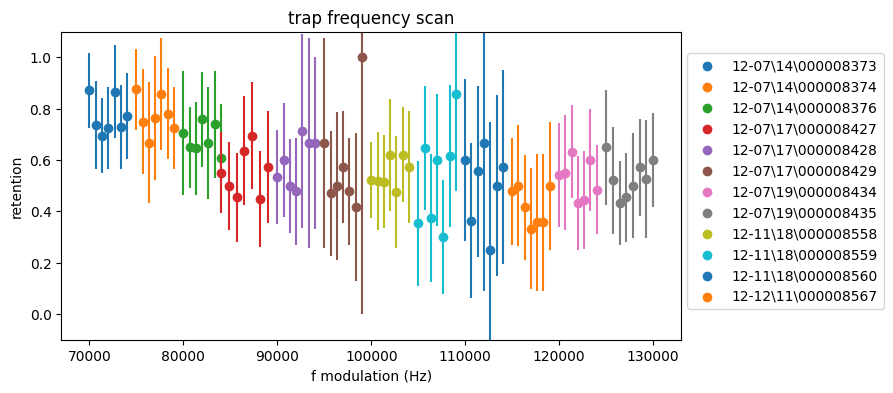

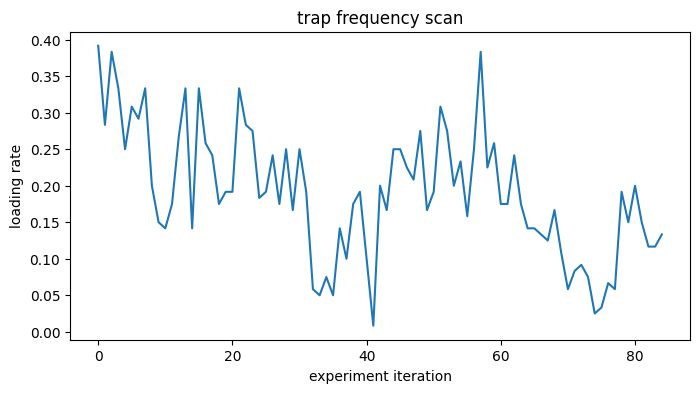

In [141]:
plot_retention = True
cutoff = 180

counts_shot1_list = []
counts_shot2_list = []
loading_rate_list = []
retention_list = []
err_list = []
f_volts_list = []

fig, ax = plt.subplots(figsize=(8,4))

for fname in fnames:
    try:
        f = h5py.File(os.path.join(results, fname))

        # assume these arguments are the same over the entire batch
        n_measurements = np.uint(f['datasets']['n_measurements'])
        
        FMdev = np.uint(f['datasets']['FM_deviation'])
        f0 = np.uint(f['datasets']['carrier_frequency'])
        f_arr = eval_str_from_h5(f['datasets']['f_modulation'])
        
        try:
            counts1 = np.array(f['datasets']['photocounts'])[1:]
            counts2 = np.array(f['datasets']['photocounts2'])[1:]

            # if this isn't true, it means there was an error during run(), e.g. the experiment was aborted
            if len(counts1) == len(f_arr)*n_measurements:
                [counts_shot1_list.append(x) for x in counts1]
                [counts_shot2_list.append(x) for x in counts2]
                f_volts = (f_arr - f0)* 5/FMdev
                [f_volts_list.append(f) for f in f_volts]

            
                retention_array = np.zeros(len(f_arr))
                loading_rate_array = np.zeros(len(f_arr))
                
                n_atoms_loaded_array = np.zeros(len(f_arr))
                
                measurements = n_measurements
                
                for i,t in enumerate(f_arr):
                    shot1 = counts1[i*measurements:(i+1)*measurements]
                    shot2 = counts2[i*measurements:(i+1)*measurements]
                    
                    atoms_loaded = [x > cutoff for x in shot1]
                    n_atoms_loaded = sum(atoms_loaded)
                    atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
                    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
                    retention_array[i] = retention_fraction
                    loading_rate_array[i] = n_atoms_loaded/n_measurements
                    n_atoms_loaded_array[i] = n_atoms_loaded

                [retention_list.append(x) for x in retention_array]
                [loading_rate_list.append(x) for x in loading_rate_array]
                
                err_array = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
                [err_list.append(x) for x in err_array]

                if plot_retention:
                    ax.scatter(f_arr, retention_array, label=fname[5:23])#,color='r')
                    # t_pts = np.linspace(t_arr[0],t_arr[-1],100)
                    ax.errorbar(f_arr,retention_array, err_array, ls='none')#,color='r')
            else:
                print("Experiment aborted:",fname,len(counts1),"!=",len(f_arr)*n_measurements)
        
        except KeyError as e:
            print("Exception in", fname,",",e)
    
    except OSError:
        print(fname, "is corrupt :/")
   
counts_shot1 = np.array(counts_shot1_list)
counts_shot2 = np.array(counts_shot1_list)
loading_rate = np.array(loading_rate_list)

f_volts = np.array(f_volts_list)
f_abs = (f_volts+10)*(2*FMdev/10)+f0

if plot_retention:
    # plt.title('trap frequency scan')
    # plt.ylabel("retention")
    # plt.xlabel("f modulation (Hz)")
    # plt.ylim((-0.1,1.1))
    # plt.legend(loc=(1.1,0.5))
    # plt.show()

    ax.set_title('trap frequency scan')
    ax.set_ylabel("retention")
    ax.set_xlabel("f modulation (Hz)")
    ax.set_ylim((-0.1,1.1))
    ax.legend(loc=(1.01,0.1))
    plt.show()

    fig, ax = plt.subplots(figsize=(8,4))
    
    ax.plot(loading_rate)
    ax.set_title('trap frequency scan')
    ax.set_ylabel("loading rate")
    ax.set_xlabel("experiment iteration")
    plt.show()

Text(0.5, 0, 'f modulation (Hz)')

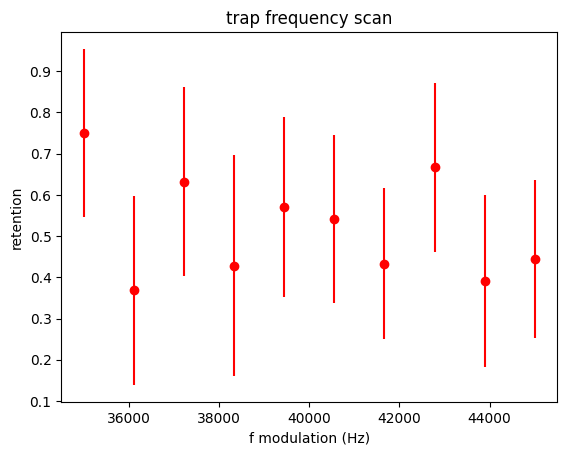

In [54]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = 180
retention_array = np.zeros(len(f_arr))
loading_rate_array = np.zeros(len(f_arr))

n_atoms_loaded_array = np.zeros(len(f_arr))

measurements = n_measurements #if not control_experiment else n_measurements//2

for i,t in enumerate(f_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(f_arr, retention_array, label='data',color='r')
# t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('trap frequency scan')
plt.errorbar(f_arr,retention_array, errs, ls='none',color='r')
plt.ylabel("retention")
plt.xlabel("f modulation (Hz)")

### 2023.12.05

In [51]:
# the first trap parametric heating frequency scan
fname = "2023-12-05\\18\\000008249-SingleAtomTrapFrequencyScan.h5" # file is corrupt

# this is the data exported from the photocount shot 1 and 2 applets
csv1 = "2023-12-05\\18\\frequency_scan_shot1.csv" # I exported the photocounts from shot 1 and shot 2
csv2 = "2023-12-05\\18\\frequency_scan_shot2.csv"

fname = "2023-12-06\\10\\000008265-SingleAtomTrapFrequencyScan.h5" # bad snr
fname = "2023-12-06\\10\\000008275-SingleAtomTrapFrequencyScan.h5" # bad snr


f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [48]:
# data = []
# file = csv1
# with open(os.path.join(results, file)) as f:
#     reader = csv.reader(f)
#     header = reader.__next__()
#     for row in reader:
#         data.append([float(x) for x in row][1])
# counts_shot1 = np.array(data)

# data = []
# file = csv2
# with open(os.path.join(results, file)) as f:
#     reader = csv.reader(f)
#     header = reader.__next__()
#     for row in reader:
#         data.append([float(x) for x in row][1])
# counts_shot2 = np.array(data)

# f_arr = np.linspace(5.0, 20.0, 10) # kHz
# n_measurements =200

In [52]:
n_measurements = np.uint(f['datasets']['n_measurements'])

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

f_arr = eval_str_from_h5(f['datasets']['f_modulation'])

Text(0.5, 0, 'f modulation (Hz)')

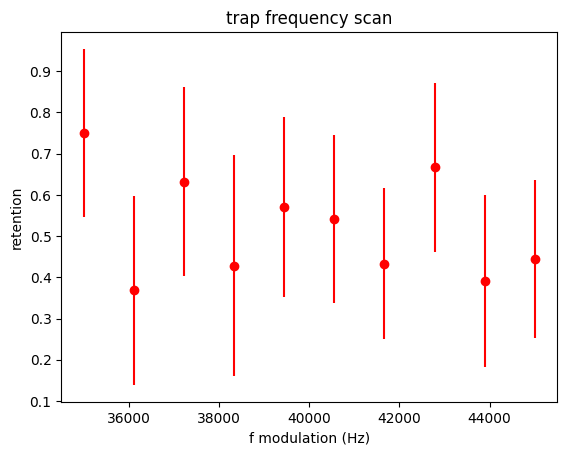

In [54]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*len(f_arr)
retention_array = np.zeros(len(f_arr))
loading_rate_array = np.zeros(len(f_arr))

n_atoms_loaded_array = np.zeros(len(f_arr))

measurements = n_measurements #if not control_experiment else n_measurements//2

for i,t in enumerate(f_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

# tau = 5 # us
# tpts = np.linspace(t_arr[0],t_arr[-1],100)/us
# plt.plot(tpts, 0.9*np.exp(-tpts/tau),color='r',linestyle='--',label=r'$\tau=$'+f'{tau}'+r'$\mu$s')

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(f_arr, retention_array, label='data',color='r')
# t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('trap frequency scan')
plt.errorbar(f_arr,retention_array, errs, ls='none',color='r')
plt.ylabel("retention")
plt.xlabel("f modulation (Hz)")